<a href="https://colab.research.google.com/github/VinaySingh561/LARGE-LANGUAGE-MODELS/blob/main/Causal_Attenion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

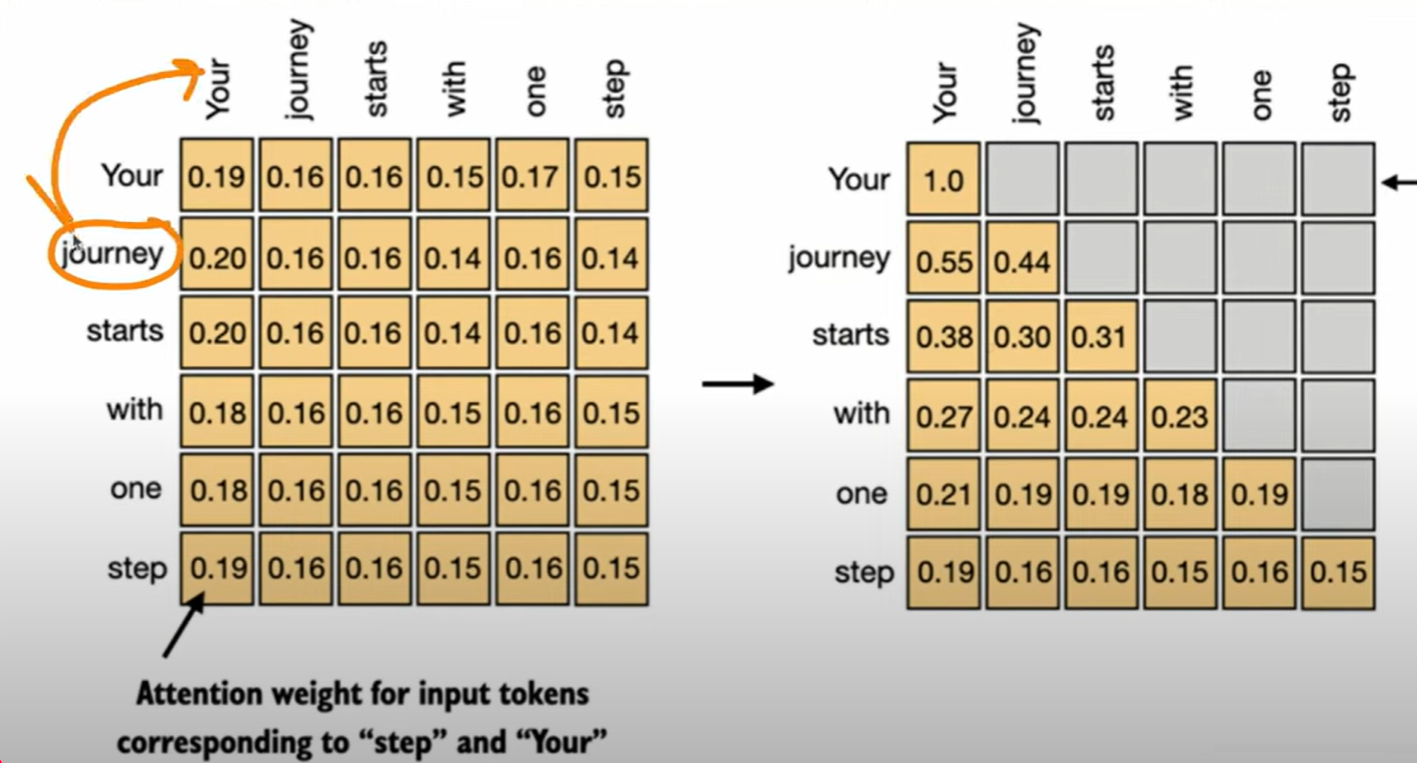

In [1]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [8]:
class self_attenion_v2(torch.nn.Module):
  def __init__(self,dim_in, dim_out,qkv_bias = False):
    super().__init__()
    self.W_query = torch.nn.Linear(dim_in,dim_out,qkv_bias)
    self.W_key = torch.nn.Linear(dim_in,dim_out,qkv_bias)
    self.W_value = torch.nn.Linear(dim_in,dim_out,qkv_bias)


  def forward(self,x):
    Query = self.W_query(x)
    Key = self.W_key(x)
    Value = self.W_value(x)

    attention_scores = (Query@Key.T)/(self.dim_out**0.5)
    attention_weights = torch.softmax(attention_scores,dim=-1)
    context_vector = attention_weights@Value
    return context_vector


In [12]:
d_in = 3
d_out =2
sa_v2 = self_attenion_v2(d_in,d_out)
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries@keys.T
attention_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)
print(attention_weights)

tensor([[0.1657, 0.1646, 0.1649, 0.1674, 0.1737, 0.1637],
        [0.1641, 0.1614, 0.1622, 0.1689, 0.1832, 0.1603],
        [0.1643, 0.1618, 0.1625, 0.1687, 0.1821, 0.1606],
        [0.1646, 0.1626, 0.1632, 0.1687, 0.1787, 0.1623],
        [0.1685, 0.1702, 0.1699, 0.1639, 0.1599, 0.1677],
        [0.1625, 0.1585, 0.1596, 0.1709, 0.1894, 0.1591]],
       grad_fn=<SoftmaxBackward0>)


In [13]:
## now creating the lower triangluar matrix
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [14]:
masked_simple = attention_weights*mask_simple
print(masked_simple)

tensor([[0.1657, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1641, 0.1614, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1643, 0.1618, 0.1625, 0.0000, 0.0000, 0.0000],
        [0.1646, 0.1626, 0.1632, 0.1687, 0.0000, 0.0000],
        [0.1685, 0.1702, 0.1699, 0.1639, 0.1599, 0.0000],
        [0.1625, 0.1585, 0.1596, 0.1709, 0.1894, 0.1591]],
       grad_fn=<MulBackward0>)


In [16]:
causal_attention_weights = masked_simple/(torch.sum(masked_simple,dim=-1,keepdim=True))
print(causal_attention_weights)
### this is acutally leaking data , as we are seeing the future data

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5041, 0.4959, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3362, 0.3311, 0.3327, 0.0000, 0.0000, 0.0000],
        [0.2498, 0.2467, 0.2476, 0.2559, 0.0000, 0.0000],
        [0.2024, 0.2045, 0.2041, 0.1969, 0.1921, 0.0000],
        [0.1625, 0.1585, 0.1596, 0.1709, 0.1894, 0.1591]],
       grad_fn=<DivBackward0>)


In [25]:
### so instead of using the attention two times, we calculate attention and then multiply it with -inf upper
## triangular which masks out the future values
d_in = 3
d_out =2
sa_v2 = self_attenion_v2(d_in,d_out)
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries@keys.T
context_length = attn_scores.shape[0]
upper_triangular_inf = -torch.triu(torch.full((context_length,context_length),torch.inf),diagonal=1)
print(upper_triangular_inf)

tensor([[-0., -inf, -inf, -inf, -inf, -inf],
        [-0., -0., -inf, -inf, -inf, -inf],
        [-0., -0., -0., -inf, -inf, -inf],
        [-0., -0., -0., -0., -inf, -inf],
        [-0., -0., -0., -0., -0., -inf],
        [-0., -0., -0., -0., -0., -0.]])


In [28]:
causal_attention_weights = torch.softmax(attn_scores + upper_triangular_inf,dim=-1)
print(causal_attention_weights) ## without leaking the data

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5222, 0.4778, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3520, 0.3224, 0.3256, 0.0000, 0.0000, 0.0000],
        [0.2601, 0.2475, 0.2489, 0.2434, 0.0000, 0.0000],
        [0.2036, 0.1948, 0.1958, 0.1913, 0.2145, 0.0000],
        [0.1741, 0.1635, 0.1646, 0.1603, 0.1877, 0.1498]],
       grad_fn=<SoftmaxBackward0>)


### Dropout before and after Calculating attention scores

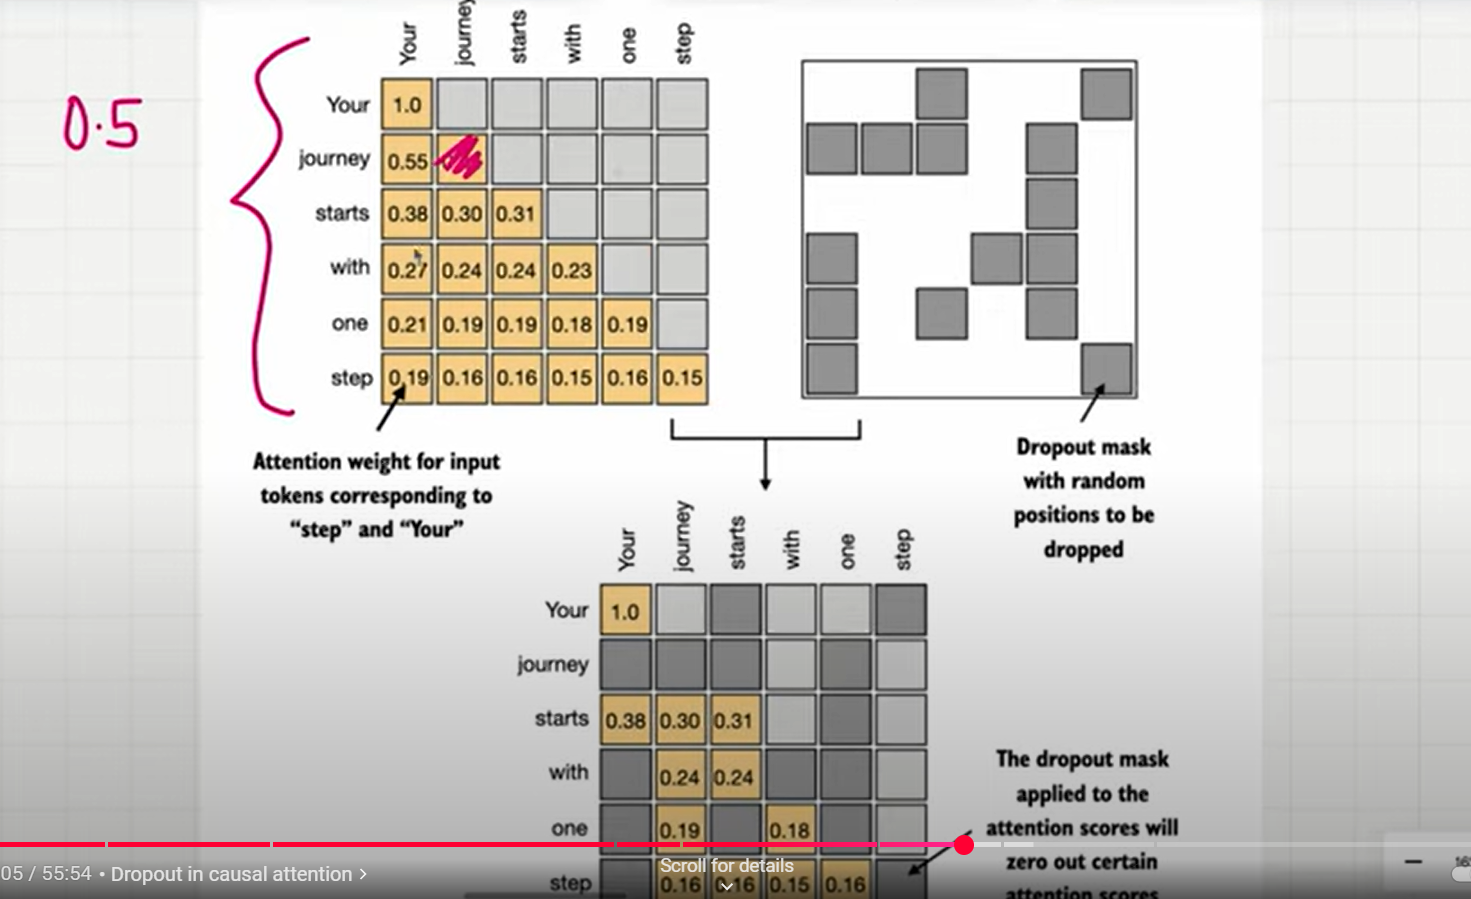

In [29]:
example = torch.ones(6,6)
print(example)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


<div class="alert alert-block alert-info">

When applying dropout to an attention weight matrix with a rate of 50%, half of the
elements in the matrix are randomly set to zero.

To compensate for the reduction in active
elements, the values of the remaining elements in the matrix are scaled up by a factor of
1/0.5 =2.

This scaling is crucial to maintain the overall balance of the attention weights,
ensuring that the average influence of the attention mechanism remains consistent during
both the training and inference phases.
</div>

In [34]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [35]:
print(dropout(causal_attention_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6512, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4951, 0.0000, 0.4868, 0.0000, 0.0000],
        [0.0000, 0.3897, 0.3917, 0.3825, 0.4290, 0.0000],
        [0.3483, 0.3269, 0.0000, 0.0000, 0.3754, 0.2995]],
       grad_fn=<MulBackward0>)


## Causal Attention class

In [56]:
class Causal_attention(torch.nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,qkv_bias = False):
    super().__init__()
    self.W_query = torch.nn.Linear(d_in,d_out,bias = qkv_bias)
    self.W_key = torch.nn.Linear(d_in,d_out,bias = qkv_bias)
    self.W_value = torch.nn.Linear(d_in,d_out,bias = qkv_bias)
    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # useful when trainng on GPU

  def forward(self,x):
    batch,num_tokens,d_in = x.shape
    Query = self.W_query(x)
    Key = self.W_key(x)
    Value = self.W_value(x)

    attenion_scores = Query@Key.transpose(1,2)
    attenion_scores.masked_fill_(
        self.mask.bool()[:num_tokens,:num_tokens],-torch.inf
    )
    attention_weights = torch.softmax(
        attenion_scores/(Key.shape[1]**0.5),dim=-1
    )
    attention_weights = self.dropout(attention_weights)
    context_vector = attention_weights@Value
    return context_vector




In [65]:
causal_inputs = torch.stack((inputs,inputs),dim=0)
print(causal_inputs.shape)
d_in, d_out = 3,2
context_length = causal_inputs.shape[1]
dropout  = 0.1

torch.Size([2, 6, 3])


In [66]:
torch.manual_seed(123)
Context_vector_causal = Causal_attention(d_in,d_out,context_length,dropout)

In [67]:
vector_context = Context_vector_causal(causal_inputs)
print(vector_context)

tensor([[[-0.5021,  0.2462],
         [-0.6506,  0.0097],
         [-0.6983, -0.0674],
         [-0.5054, -0.1532],
         [-0.6124, -0.1086],
         [-0.5878, -0.1192]],

        [[-0.5021,  0.2462],
         [-0.4044, -0.1110],
         [-0.4312,  0.0065],
         [-0.6293, -0.0925],
         [-0.4513, -0.0641],
         [-0.5094, -0.0912]]], grad_fn=<UnsafeViewBackward0>)
